In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import seaborn as sns

In [2]:
import os
import sys

In [3]:
# chaging directory

In [4]:

root, *_ = !pwd

In [5]:
if root.endswith('notebooks'):
    os.chdir('../')
    root, *_ = !pwd

In [6]:
os.getcwd()

'/home/med/projects/competitions/mlb-kaggle'

In [7]:
from dotenv import load_dotenv
load_dotenv()

True

In [8]:
RAW_PATH = Path(os.environ['RAW_PATH'])

In [9]:
os.listdir(RAW_PATH)

['seasons.csv',
 'teams.csv',
 'example_sample_submission.csv',
 'train.csv',
 'mlb-player-digital-engagement-forecasting.zip',
 'awards.csv',
 'players.csv',
 'example_test.csv',
 'mlb']

In [10]:
train_data = pd.read_csv(RAW_PATH / 'train.csv', parse_dates=['date'])
train_data = train_data.set_index('date')

In [11]:
train_data.head()

,nextDayPlayerEngagement,games,rosters,playerBoxScores,teamBoxScores,transactions,standings,awards,events,playerTwitterFollowers,teamTwitterFollowers
date,,,,,,,,,,,
2018-01-01,"[{""engagementMetricsDate"":""2018-01-02"",""player...",NaN,"[{""playerId"":400121,""gameDate"":""2018-01-01"",""t...",NaN,NaN,"[{""transactionId"":340732,""playerId"":547348,""pl...",NaN,NaN,NaN,"[{""date"":""2018-01-01"",""playerId"":545361,""playe...","[{""date"":""2018-01-01"",""teamId"":147,""teamName"":..."
2018-01-02,"[{""engagementMetricsDate"":""2018-01-03"",""player...",NaN,"[{""playerId"":134181,""gameDate"":""2018-01-02"",""t...",NaN,NaN,"[{""transactionId"":339458,""playerId"":621173,""pl...",NaN,NaN,NaN,NaN,NaN
2018-01-03,"[{""engagementMetricsDate"":""2018-01-04"",""player...",NaN,"[{""playerId"":425492,""gameDate"":""2018-01-03"",""t...",NaN,NaN,"[{""transactionId"":347527,""playerId"":572389,""pl...",NaN,NaN,NaN,NaN,NaN
2018-01-04,"[{""engagementMetricsDate"":""2018-01-05"",""player...",NaN,"[{""playerId"":282332,""gameDate"":""2018-01-04"",""t...",NaN,NaN,"[{""transactionId"":339549,""playerId"":545343,""pl...",NaN,NaN,NaN,NaN,NaN
2018-01-05,"[{""engagementMetricsDate"":""2018-01-06"",""player...",NaN,"[{""playerId"":282332,""gameDate"":""2018-01-05"",""t...",NaN,NaN,"[{""transactionId"":341195,""playerId"":628336,""pl...",NaN,NaN,NaN,NaN,NaN


In [12]:
# train_data = train_data[train_data.index > '2021-01-01']

In [13]:
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd


def pandas_hstack(Xs):
    return pd.concat([X.reset_index(drop=True) for X in Xs], axis=1)

class PdColumnTransformer(ColumnTransformer):
    def _hstack(self, Xs):
        return pandas_hstack(Xs)

class PdFeatureUnion(FeatureUnion):
    def _hstack(self, Xs):
        return pandas_hstack(Xs)

def unpack_json(json_str):
    return np.nan if pd.isna(json_str) else pd.read_json(json_str)

def unpack_column(series: pd.DataFrame) -> pd.DataFrame:
    def _unpack_row(index, row):
        out_df = unpack_json(row)
        out_df = out_df.assign(date=index)
        return out_df
    
    return pd.concat([_unpack_row(index, row)
                      for index, row in series.iteritems()
                      if pd.notna(row)], ignore_index=True)

def make_unpack_tmf(column_name):
    return PdColumnTransformer([(column_name, FunctionTransformer(unpack_column), column_name,
                                        )])

### rosters 

In [14]:
unpack_rosters = make_unpack_tmf('rosters')

In [15]:
rosters = unpack_rosters.fit_transform(train_data)

In [16]:
rosters.head()

,playerId,gameDate,teamId,statusCode,status,date
0,400121,2018-01-01,116,A,Active,2018-01-01
1,408045,2018-01-01,142,A,Active,2018-01-01
2,425492,2018-01-01,120,A,Active,2018-01-01
3,429664,2018-01-01,136,A,Active,2018-01-01
4,431151,2018-01-01,121,A,Active,2018-01-01


### players stats boxscores 

In [17]:
unpack_boxscores = make_unpack_tmf('playerBoxScores')

In [18]:
def player_stats_preprocessing(df: pd.DataFrame) -> pd.DataFrame:
    to_keep = ['date', 'teamId', 'playerId', 'teamName', 'gameDate']
    return (df[to_keep].drop_duplicates().
            reset_index(drop=True))

In [19]:
unpack_boxscores = make_unpack_tmf('playerBoxScores')
player_game_stats_pipeline = Pipeline([('unpack', unpack_boxscores),
                                       ('preprocessing', FunctionTransformer(player_stats_preprocessing))])

In [20]:
player_game_stats = player_game_stats_pipeline.fit_transform(train_data)

player_game_stats_pipeline

Pipeline(steps=[('unpack',
                 PdColumnTransformer(transformers=[('playerBoxScores',
                                                    FunctionTransformer(func=<function unpack_column at 0x7f79cdcb8f70>),
                                                    'playerBoxScores')])),
                ('preprocessing',
                 FunctionTransformer(func=<function player_stats_preprocessing at 0x7f79ce3de940>))])

In [28]:
test_players = pp.query('player_in_test')

In [38]:
test_players['playerId'].isin(player_game_stats['playerId'].unique()).mean()

0.9612468407750632

In [33]:
player_game_stats['playerId'].nunique()

2004

In [42]:
test_players['playerId'].isin(rosters.playerId.unique()).mean()

0.9814658803706824

In [35]:
test_players['playerId'].nunique()

1187

### season

In [20]:
from typing import List


def date_preprocessing(df,
                       path_to_season: str,
                       dt_col: str = 'date',
                       date_attr: List[str] = ['year', 'month']):
    assert 'year' in date_attr, \
            'year attr must be on the date_attr list'
    seasons = pd.read_csv(path_to_season)
    
    # adding date attr
    for attr in date_attr:
        attr = attr.lower()
        df[attr] = getattr(df[dt_col].dt, attr)

    season_df = pd.merge(df, seasons, left_on='year', right_on='seasonId')

    season_df['inSeason'] = (season_df['date'].between(
                                    season_df['regularSeasonStartDate'],
                                    season_df['postSeasonEndDate'],
                                    inclusive = True
                                    )
                                  )

    season_df['seasonPart'] = np.select(
      [
        season_df['date'] < season_df['preSeasonStartDate'], 
        season_df['date'] < season_df['regularSeasonStartDate'],
        season_df['date'] <= season_df['lastDate1stHalf'],
        season_df['date'] < season_df['firstDate2ndHalf'],
        season_df['date'] <= season_df['regularSeasonEndDate'],
        season_df['date'] < season_df['postSeasonStartDate'],
        season_df['date'] <= season_df['postSeasonEndDate'],
        season_df['date'] > season_df['postSeasonEndDate']
      ], 
      [
        'Offseason',
        'Preseason',
        'Reg Season 1st Half',
        'All-Star Break',
        'Reg Season 2nd Half',
        'Between Reg and Postseason',
        'Postseason',
        'Offseason'
      ], 
      default = np.nan
      )

    season_df.drop(seasons.columns, axis=1, inplace=True)
    
    return season_df

In [21]:
### template

In [22]:
dates = train_data.reset_index()[['date']]

In [23]:
dates = date_preprocessing(dates, RAW_PATH / 'seasons.csv',
                   date_attr=['year', 'month', 'week'])

<ipython-input-20-cf85cdc2b8d2>:15: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df[attr] = getattr(df[dt_col].dt, attr)


In [24]:
dates

,date,year,month,week,inSeason,seasonPart
0,2018-01-01,2018,1,1,False,Offseason
1,2018-01-02,2018,1,1,False,Offseason
2,2018-01-03,2018,1,1,False,Offseason
3,2018-01-04,2018,1,1,False,Offseason
4,2018-01-05,2018,1,1,False,Offseason
...,...,...,...,...,...,...
1211,2021-04-26,2021,4,17,True,Reg Season 1st Half
1212,2021-04-27,2021,4,17,True,Reg Season 1st Half
1213,2021-04-28,2021,4,17,True,Reg Season 1st Half
1214,2021-04-29,2021,4,17,True,Reg Season 1st Half


### teams

In [21]:
from datetime import datetime as dt

In [22]:
players = pd.read_csv(RAW_PATH / 'players.csv', parse_dates=['DOB', 'mlbDebutDate'])

In [23]:
def player_preprocessing(players: pd.DataFrame) -> pd.DataFrame:
    players.rename(columns={'playerForTestSetAndFuturePreds': 'player_in_test'}, inplace=True)
    # fill nan values with false
    players['player_in_test'] = players['player_in_test'].fillna(False)
    
    #should be dt.now() but fow now lets fix it
    current_date = pd.to_datetime('2021-06-14')
#     players['playerAge'] =  (current_date - players['DOB']).dt.total_seconds()
#     players['playerTimeSinceDebut'] = (current_date - players['mlbDebutDate']).dt.total_seconds()
#     players['playerDebutAge'] = (players['mlbDebutDate'] - players['DOB']).dt.total_seconds()
#     # seconds to year
#     players[['playerAge', 'playerTimeSinceDebut', 'playerDebutAge']] /= 60 * 60 * 24 * 365
    # weight to kg and height to cm
    players['weight'] *= 0.453592
    players['height'] = players['heightInches'] * 2.54 / 100
    players['playerBMI'] = players['weight'] / np.power(players['height'], 2)
    
    # drop unnecessary features
    to_drop = ['birthCity', 'heightInches',
               'birthStateProvince',
               'primaryPositionCode', 'playerName']
    players.drop(to_drop, inplace=True, axis=1)
    return players

In [24]:
players.isna().mean()

playerId                          0.000000
playerName                        0.000000
DOB                               0.000000
mlbDebutDate                      0.017467
birthCity                         0.000000
birthStateProvince                0.264435
birthCountry                      0.000000
heightInches                      0.000000
weight                            0.000000
primaryPositionCode               0.000000
primaryPositionName               0.000000
playerForTestSetAndFuturePreds    0.001941
dtype: float64

In [25]:
pp = player_preprocessing(players)

In [26]:
pp.isna().mean()

playerId               0.000000
DOB                    0.000000
mlbDebutDate           0.017467
birthCountry           0.000000
weight                 0.000000
primaryPositionName    0.000000
player_in_test         0.000000
height                 0.000000
playerBMI              0.000000
dtype: float64

### target 

In [31]:
# transforming
def target_preprocessing(target: pd.DataFrame) -> pd.DataFrame:
    target.drop('engagementMetricsDate', axis=1, inplace=True)
    target['target_avg'] = target[[f'target{i}' for i in range(1, 5)]].mean(axis=1)
    return target

In [32]:
unpack_target_tmf = make_unpack_tmf('nextDayPlayerEngagement')

target_pipeline = Pipeline([('unpack_target', unpack_target_tmf),
                            ('preprocessing', FunctionTransformer(target_preprocessing))])

In [33]:
target_pipeline

Pipeline(steps=[('unpack_target',
                 PdColumnTransformer(transformers=[('nextDayPlayerEngagement',
                                                    FunctionTransformer(func=<function unpack_column at 0x7f59dae74f70>),
                                                    'nextDayPlayerEngagement')])),
                ('preprocessing',
                 FunctionTransformer(func=<function target_preprocessing at 0x7f593b6a95e0>))])

In [34]:
%time target = target_pipeline.fit_transform(train_data)

CPU times: user 16 s, sys: 248 ms, total: 16.3 s
Wall time: 16.3 s


In [35]:
target.head()

,playerId,target1,target2,target3,target4,date,target_avg
0,628317,0.011167,4.474708,0.005168,5.735294,2018-01-01,2.556584
1,547989,0.042993,5.593385,0.045033,2.794118,2018-01-01,2.118882
2,519317,0.974327,56.177043,13.693746,64.166667,2018-01-01,33.752945
3,607625,0.006700,2.675097,0.005168,1.862745,2018-01-01,1.137428
4,592547,0.001117,0.632296,0.002953,0.931373,2018-01-01,0.391934


### standings

In [36]:
# def get_feature_by_dtype(df: pd.DataFrame, dtype: np.dtype):
#     return [feature for feature, value in df.items()
#             if value.dtype == dtype]

# def standing_preprocessing(df: pd.DataFrame) -> pd.DataFrame:
#     def _streak(df: pd.DataFrame):
#         df['streakCode'] = df['streakCode'].fillna('W0')
#         winning_idx = df['streakCode'].str.startswith('W')
#         game_streak = df['streakCode'].apply(lambda x: x[1:]).astype(np.float32)        
#         # double column
# #         df.loc[winning_idx, 'winStreak'] = streak[winning_idx]
# #         df.loc[~winning_idx, 'loseStreak'] = streak[~winning_idx]
# #         df.fillna(0, subset=['winStreak', 'loseStreak'], inplace=True)
#         # one column
#         df['gameStreak'] = game_streak * np.where(winning_idx, 1, -1)
        
#         df.drop('streakCode', axis=1, inplace=True)
#         return df

#     # streak
#     df = _streak(df)
#     # min value set to 0
#     df.loc[:, 'divisionRank'] -= 1
#     # normalize from 0 to 1
#     df.loc[:, 'leagueRank'] /= 15
#     # normalize from 0 to 1 and set nan values to 0.5
#     df.loc[:, 'wildCardRank'] = np.where(pd.notna(df['wildCardRank']),
#                                   df['wildCardRank'] / 15,
#                                   0.5)

#     # columns with nan as - or none
#     nan_as_tokens = ['leagueGamesBack',
#                   'sportGamesBack',
#                   'divisionGamesBack',
#                   'eliminationNumber',
#                   'wildCardEliminationNumber',
#                   'wildCardLeader']
#     df.loc[:, nan_as_tokens] = df.loc[:, nan_as_tokens].replace({'-': np.nan, None: np.nan})

#     # games back
#     games_back_cols = ['leagueGamesBack', 'divisionGamesBack']
#     # filling nan values as 0
#     df.loc[:, games_back_cols] = df[games_back_cols].astype(np.float32).fillna(0)
#     # sportGamesBack == leagueGamesBack, removing redundancy
#     df.drop('sportGamesBack', axis=1, inplace=True)

    
#     # elimination games,  for the moment lets fill na with -1
#     elimination_cols = ['eliminationNumber',
#                         'wildCardEliminationNumber']
#     df.loc[:, elimination_cols] = (df.loc[:, elimination_cols].replace({'E': -1}).
#                                    astype(np.float32).fillna(-1))
    
#     # to boolean and fill na with false
#     df.loc[:, 'wildCardLeader'] = df['wildCardLeader'].fillna(False).astype(np.bool_)
    
#     # boolean to float32
#     boolean_features = get_feature_by_dtype(df, np.bool_)
#     df.loc[:, boolean_features] = df[boolean_features].astype(np.float32)
    
#     # fillna with -1
#     al_nl_cols = ['alWins', 'alLosses', 'nlWins', 'nlLosses']
#     df.loc[:, al_nl_cols] = df[al_nl_cols].fillna(-1)
    
# #     # dropping gameDate 
# #     to_drop = ['gameDate', 'divisionId', 'teamName',
# #                 'divisionChamp', 'season', 
# #                 'turfWins', 'turfLosses',
# #                 'grassWins', 'grassLosses',
# #                 'dayWins', 'dayLosses', 
# #                 'nightWins', 'nightLosses', 
# #                 'oneRunWins', 'oneRunLosses',
# #                 'eliminationNumber', 'wildCardEliminationNumber',
# #                 'leagueGamesBack',
# #                 'sportGamesBack',
# #                 'divisionGamesBack',
# #                 'extraInningWins',
# #                 'extraInningLosses',
# #                'oneRunWins', 'oneRunLosses'
# #                 'wildCardLeader']

#     df.rename(columns={'pct': 'winPct'}, inplace=True)
#     df['total_games'] = df[['wins', 'losses']].sum()
#     df['HomeWinPct'] = (df['homeWins'] / df[['homeWins', 'homeLosses']].sum())
#     df['AwayWinPct'] = (df['awayWins'] / df[['awayWins', 'awayLosses']].sum())
#     df['lastTenWinsPct'] = df['lastTenWins'] / 10
    
    
    
#     df.drop(to_drop,
#              axis=1, inplace=True)
    
#     rename_columns = df.columns.drop(['teamId', 'date'])
    
#     df.rename(columns={f: f'{f}Team' for f in rename_columns}, inplace=True)
#     return df

In [37]:
def get_feature_by_dtype(df: pd.DataFrame, dtype: np.dtype):
    return [feature for feature, value in df.items()
            if value.dtype == dtype]

def divide(x, y):
    y[y==0] = 1
    return x / (y)

def standing_preprocessing(df: pd.DataFrame) -> pd.DataFrame:
    def _streak(df: pd.DataFrame):
        df['streakCode'] = df['streakCode'].fillna('W0')
        winning_idx = df['streakCode'].str.startswith('W')
        game_streak = df['streakCode'].apply(lambda x: x[1:]).astype(np.float32)        
        # double column
#         df.loc[winning_idx, 'winStreak'] = streak[winning_idx]
#         df.loc[~winning_idx, 'loseStreak'] = streak[~winning_idx]
#         df.fillna(0, subset=['winStreak', 'loseStreak'], inplace=True)
        # one column
        df['gameStreak'] = game_streak * np.where(winning_idx, 1, -1)
        
        df.drop('streakCode', axis=1, inplace=True)
        return df

    # streak
    df = _streak(df)
    # normalize from 0 to 1
    df.loc[:, 'leagueRank'] /= 15

    df.rename(columns={'pct': 'winPct'}, inplace=True)
    df['gamesSoFar'] = df[['wins', 'losses']].sum(axis=1)
    df['homeWinPct'] = df['homeWins'] / df[['homeWins', 'homeLosses']].sum(axis=1)
    df['awayWinPct'] = df['awayWins'] / df[['awayWins', 'awayLosses']].sum(axis=1)
    df['lastTenWinsPct'] = df['lastTenWins'] / 10
    df['runsPct'] = divide(df['runsScored'], df[['runsScored', 'runsAllowed']].sum(axis=1))
    
    # make sure if any div by 0 was occured
    pct_columns = [f for f in df.columns
                   if f.lower().endswith('pct')]
    df[pct_columns] = df[pct_columns].fillna(0)
    
    
    to_keep = ['gamesSoFar', 'homeWinPct', 'awayWinPct', 
               'lastTenWinsPct', 'winPct', 'leagueRank',
               'xWinLossPct', 'runsScored',
               'runsAllowed', 'runsPct']
    
    df = df.loc[:, to_keep + ['teamId', 'date']]
    
    rename_columns = df.columns.drop(['teamId', 'date'])
    
    df.rename(columns={f: f'{f}Team' for f in rename_columns}, inplace=True)
    return df

In [38]:
standing_pipeline = Pipeline([('unpack', make_unpack_tmf('standings')),
                              ('preprocessing', FunctionTransformer(standing_preprocessing))])

In [39]:
standing_pipeline

Pipeline(steps=[('unpack',
                 PdColumnTransformer(transformers=[('standings',
                                                    FunctionTransformer(func=<function unpack_column at 0x7f59dae74f70>),
                                                    'standings')])),
                ('preprocessing',
                 FunctionTransformer(func=<function standing_preprocessing at 0x7f593c54dd30>))])

In [40]:
%%time
standings = standing_pipeline.fit_transform(train_data) 

CPU times: user 8.33 s, sys: 9.13 ms, total: 8.34 s
Wall time: 8.33 s


In [41]:
standings.columns

Index(['gamesSoFarTeam', 'homeWinPctTeam', 'awayWinPctTeam',
       'lastTenWinsPctTeam', 'winPctTeam', 'leagueRankTeam', 'xWinLossPctTeam',
       'runsScoredTeam', 'runsAllowedTeam', 'runsPctTeam', 'teamId', 'date'],
      dtype='object')

In [42]:
standings.isna().mean()

gamesSoFarTeam        0.0
homeWinPctTeam        0.0
awayWinPctTeam        0.0
lastTenWinsPctTeam    0.0
winPctTeam            0.0
leagueRankTeam        0.0
xWinLossPctTeam       0.0
runsScoredTeam        0.0
runsAllowedTeam       0.0
runsPctTeam           0.0
teamId                0.0
date                  0.0
dtype: float64

In [43]:
standings.head()

,gamesSoFarTeam,homeWinPctTeam,awayWinPctTeam,lastTenWinsPctTeam,winPctTeam,leagueRankTeam,xWinLossPctTeam,runsScoredTeam,runsAllowedTeam,runsPctTeam,teamId,date
0,1,0.0,1.0,0.1,1.0,0.200000,0.0,8,4,0.666667,112,2018-03-29
1,1,0.0,0.0,0.0,0.0,0.800000,0.0,4,8,0.333333,146,2018-03-29
2,1,1.0,0.0,0.1,1.0,0.333333,1.0,9,4,0.692308,121,2018-03-29
3,1,0.0,0.0,0.0,0.0,0.933333,0.0,1,4,0.200000,140,2018-03-29
4,1,1.0,0.0,0.1,1.0,0.133333,0.0,8,5,0.615385,144,2018-03-29


### merge 

In [44]:
# import gc
# del train_data
# gc.collect()

In [45]:
def ffill_forward(df, features, id_feats = ['playerId']):
    ff_df = df.groupby(id_feats)[features].ffill()
    df.update(ff_df)
    return df

In [46]:
df = target.copy()

In [47]:
df.sort_values(by=['playerId', 'date'], inplace=True)

In [48]:
df = df.merge(dates, on=['date'], how='left')

In [49]:
df.head()

,playerId,target1,target2,target3,target4,date,target_avg,year,month,week,inSeason,seasonPart
0,112526,0.055277,5.496109,0.025839,16.176471,2018-01-01,5.438424,2018,1,1,False,Offseason
1,112526,0.060625,3.252914,0.030486,8.541353,2018-01-02,2.971345,2018,1,1,False,Offseason
2,112526,0.029341,1.648352,0.032613,10.490112,2018-01-03,3.050104,2018,1,1,False,Offseason
3,112526,0.014799,2.665894,0.087422,19.091467,2018-01-04,5.464896,2018,1,1,False,Offseason
4,112526,0.083916,1.161002,0.024759,6.643880,2018-01-05,1.978389,2018,1,1,False,Offseason


In [50]:
df.isna().mean()

playerId      0.0
target1       0.0
target2       0.0
target3       0.0
target4       0.0
date          0.0
target_avg    0.0
year          0.0
month         0.0
week          0.0
inSeason      0.0
seasonPart    0.0
dtype: float64

In [51]:
df = df.merge(pp, on=['playerId'], how='left')

In [52]:
df.isna().mean()

playerId               0.000000
target1                0.000000
target2                0.000000
target3                0.000000
target4                0.000000
date                   0.000000
target_avg             0.000000
year                   0.000000
month                  0.000000
week                   0.000000
inSeason               0.000000
seasonPart             0.000000
DOB                    0.000000
mlbDebutDate           0.017467
birthCountry           0.000000
weight                 0.000000
primaryPositionName    0.000000
player_in_test         0.000000
height                 0.000000
playerBMI              0.000000
dtype: float64

In [53]:
# # merging game stats
# df = df.merge(player_game_stats,
#               on=['date', 'playerId'],
#               how='left')
df = df.merge(rosters, on=['date', 'playerId'], how='left')

In [55]:
df.isna().mean()

playerId               0.000000
target1                0.000000
target2                0.000000
target3                0.000000
target4                0.000000
date                   0.000000
target_avg             0.000000
year                   0.000000
month                  0.000000
week                   0.000000
inSeason               0.000000
seasonPart             0.000000
DOB                    0.000000
mlbDebutDate           0.017467
birthCountry           0.000000
weight                 0.000000
primaryPositionName    0.000000
player_in_test         0.000000
height                 0.000000
playerBMI              0.000000
gameDate               0.427582
teamId                 0.427582
statusCode             0.427582
status                 0.427582
dtype: float64

In [57]:
df = ffill_forward(df, features=rosters.columns.drop('date'))

In [63]:
df.isna().mean()

playerId               0.000000
target1                0.000000
target2                0.000000
target3                0.000000
target4                0.000000
date                   0.000000
target_avg             0.000000
year                   0.000000
month                  0.000000
week                   0.000000
inSeason               0.000000
seasonPart             0.000000
DOB                    0.000000
mlbDebutDate           0.017467
birthCountry           0.000000
weight                 0.000000
primaryPositionName    0.000000
player_in_test         0.000000
height                 0.000000
playerBMI              0.000000
gameDate               0.188572
teamId                 0.188572
statusCode             0.188572
status                 0.188572
dtype: float64

In [64]:
dfsp = df.copy()

In [65]:
dfsp['nan'] = dfsp['teamId'].isna()

In [68]:
dfsp.groupby(['date'])['nan'].sum()

date
2018-01-01    969
2018-01-02    969
2018-01-03    969
2018-01-04    968
2018-01-05    968
             ... 
2021-04-26     25
2021-04-27     23
2021-04-28     23
2021-04-29     23
2021-04-30     23
Name: nan, Length: 1216, dtype: int64

In [174]:
# merging standing stats
df = df.merge(standings, on=['date', 'teamId'], how='left')
# df[standings.columns] = 

In [175]:
df.head()

,playerId,target1,target2,target3,target4,date,target_avg,year,month,week,...,gamesSoFarTeam,homeWinPctTeam,awayWinPctTeam,lastTenWinsPctTeam,winPctTeam,leagueRankTeam,xWinLossPctTeam,runsScoredTeam,runsAllowedTeam,runsPctTeam
0,112526,0.055277,5.496109,0.025839,16.176471,2018-01-01,5.438424,2018,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,112526,0.060625,3.252914,0.030486,8.541353,2018-01-02,2.971345,2018,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,112526,0.029341,1.648352,0.032613,10.490112,2018-01-03,3.050104,2018,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,112526,0.014799,2.665894,0.087422,19.091467,2018-01-04,5.464896,2018,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,112526,0.083916,1.161002,0.024759,6.643880,2018-01-05,1.978389,2018,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [176]:
df.columns

Index(['playerId', 'target1', 'target2', 'target3', 'target4', 'date',
       'target_avg', 'year', 'month', 'week', 'inSeason', 'seasonPart', 'DOB',
       'mlbDebutDate', 'birthCountry', 'weight', 'primaryPositionName',
       'player_in_test', 'height', 'playerBMI', 'teamId', 'teamName',
       'gameDate', 'gamesSoFarTeam', 'homeWinPctTeam', 'awayWinPctTeam',
       'lastTenWinsPctTeam', 'winPctTeam', 'leagueRankTeam', 'xWinLossPctTeam',
       'runsScoredTeam', 'runsAllowedTeam', 'runsPctTeam'],
      dtype='object')

In [88]:
# lets work just with in season data

In [89]:
df = df.query('inSeason')

In [90]:
df.head()

,playerId,target1,target2,target3,target4,date,target_avg,year,month,week,...,gamesSoFarTeam,homeWinPctTeam,awayWinPctTeam,lastTenWinsPctTeam,winPctTeam,leagueRankTeam,xWinLossPctTeam,runsScoredTeam,runsAllowedTeam,runsPctTeam
87,112526,0.031761,2.731418,0.388556,6.349412,2018-03-29,2.375287,2018,3,13,...,1.0,0.000000,0.0,0.0,0.000,0.933333,0.0,1.0,4.0,0.200000
88,112526,0.025906,4.622162,0.408017,11.508375,2018-03-30,4.141115,2018,3,13,...,2.0,0.500000,0.0,0.1,0.500,0.666667,0.0,6.0,5.0,0.545455
89,112526,0.053185,4.767842,0.275408,14.600851,2018-03-31,4.924321,2018,3,13,...,3.0,0.333333,0.0,0.1,0.333,0.800000,0.0,9.0,14.0,0.391304
90,112526,0.771100,63.601677,7.566316,100.000000,2018-04-01,42.984773,2018,4,13,...,4.0,0.250000,0.0,0.1,0.250,0.866667,0.0,11.0,22.0,0.333333
91,112526,5.957846,22.427930,33.900803,38.857939,2018-04-02,25.286130,2018,4,14,...,5.0,0.250000,0.0,0.1,0.200,0.933333,0.0,12.0,25.0,0.324324


In [91]:
df.isna().mean()

playerId               0.000000
target1                0.000000
target2                0.000000
target3                0.000000
target4                0.000000
date                   0.000000
target_avg             0.000000
year                   0.000000
month                  0.000000
week                   0.000000
inSeason               0.000000
seasonPart             0.000000
DOB                    0.000000
mlbDebutDate           0.017467
birthCountry           0.000000
weight                 0.000000
primaryPositionName    0.000000
player_in_test         0.000000
height                 0.000000
playerBMI              0.000000
teamId                 0.000000
teamName               0.000000
gameDate               0.000000
gamesSoFarTeam         0.063864
homeWinPctTeam         0.063864
awayWinPctTeam         0.063864
lastTenWinsPctTeam     0.063864
winPctTeam             0.063864
leagueRankTeam         0.063864
xWinLossPctTeam        0.063864
runsScoredTeam         0.063864
runsAllo

In [92]:
# some feature eng for the dates

In [96]:
df['playerAge'] = (df['date'] - df['DOB']).dt.total_seconds()
df['playerTSinceDebut'] = (df['date'] - df['mlbDebutDate']).dt.total_seconds()
df['playerDebutAge'] = (df['mlbDebutDate'] - df['DOB']).dt.total_seconds()
df['timeSinceLastGame'] = (df['date'] - pd.to_datetime(df['gameDate'])).dt.total_seconds()
# normalize
df[['playerAge', 'playerTSinceDebut', 'playerDebutAge']] /= 60 * 60 * 24 * 365
df['timeSinceLastGame'] /= 60 * 60 * 24

In [97]:
agg_date = df.groupby('date').mean()

In [98]:
agg_date['timeSinceLastGame'].describe()

count    567.000000
mean     -98.005203
std      223.829703
min     -698.788937
25%     -276.768802
50%      -65.731198
75%       21.237991
max      322.476953
Name: timeSinceLastGame, dtype: float64

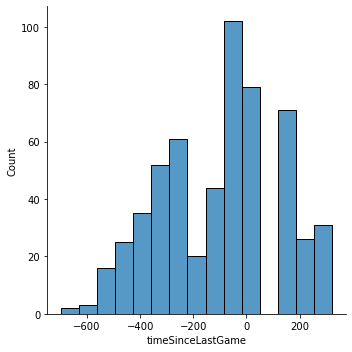

In [99]:
sns.displot(x='timeSinceLastGame', data=agg_date)